## Hierarchical Clustering from Scratch


In [1]:
import math
import random
import matplotlib.pyplot as plt

random.seed(42)

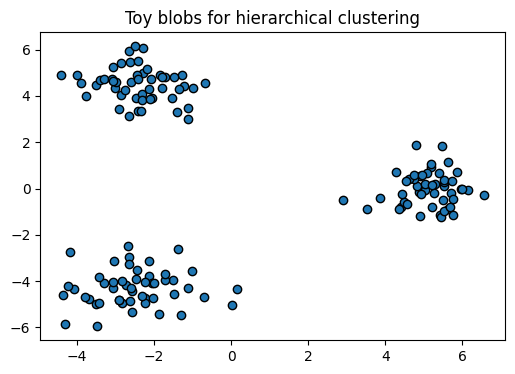

In [2]:
def generate_blobs(n_samples=150, centers=3, std=0.8):
    points = []
    for k in range(centers):
        angle = 2*math.pi * k / centers
        cx, cy = 5*math.cos(angle), 5*math.sin(angle)
        for _ in range(n_samples//centers):
            x = random.gauss(cx, std)
            y = random.gauss(cy, std)
            points.append((x, y))
    return points

X = generate_blobs()
xs, ys = zip(*X)
plt.figure(figsize=(6,4))
plt.scatter(xs, ys, edgecolors='k')
plt.title("Toy blobs for hierarchical clustering")
plt.show()

In [3]:
def euclidean(a, b):
    return math.hypot(a[0]-b[0], a[1]-b[1])

#### Agglomerative clustering (single linkage)

We start with each point as its own cluster.  
At each step, we merge the two clusters whose closest pair of points is smallest.
We record merges in a linkage list: `(idx1, idx2, dist, new_size)`.


In [4]:
def hierarchical_clustering(points):
    
    clusters = [[i] for i in range(len(points))]
    linkage = []
    
    while len(clusters) > 1:
        min_dist = float('inf')
        to_merge = (None, None)
        for i in range(len(clusters)):
            for j in range(i+1, len(clusters)):
                for pi in clusters[i]:
                    for pj in clusters[j]:
                        d = euclidean(points[pi], points[pj])
                        if d < min_dist:
                            min_dist = d
                            to_merge = (i, j)
        
        i, j = to_merge
        
        c1, c2 = clusters[i], clusters[j]
        new_cluster = c1 + c2
        linkage.append((i, j, min_dist, len(new_cluster)))
        
        clusters.pop(j)
        clusters.pop(i)
        clusters.append(new_cluster)
    
    return linkage

linkage = hierarchical_clustering(X)

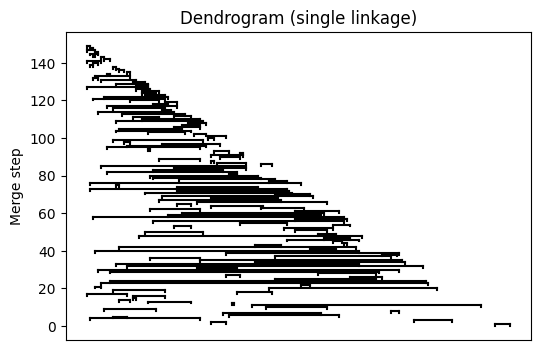

In [5]:
def plot_dendrogram(linkage):
    n = len(linkage) + 1
    
    xs = {i: i for i in range(n)}
    height = 0
    fig, ax = plt.subplots(figsize=(6, 4))
    
    for idx, (i, j, dist, size) in enumerate(linkage):
        height += 1
        xi, xj = xs[i], xs[j]
        
        ax.plot([xi, xi], [height-1, height], c='k')
        ax.plot([xj, xj], [height-1, height], c='k')
        
        ax.plot([xi, xj], [height, height], c='k')
        
        xs[n + idx] = (xi + xj)/2
    
    ax.set_ylabel("Merge step")
    ax.set_xticks([])
    ax.set_title("Dendrogram (single linkage)")
    plt.show()

plot_dendrogram(linkage)

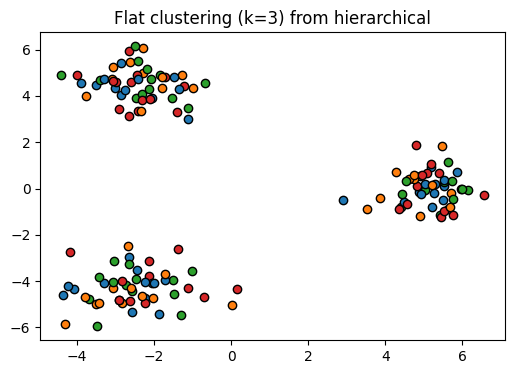

In [16]:
def flat_clusters(linkage, num_points, k):
    labels = list(range(num_points))
    clusters = {i: [i] for i in range(num_points)}
    merges_needed = num_points - k
    
    for row_idx, (i, j, dist, size) in enumerate(linkage):
        if row_idx >= merges_needed:
            break
        i, j = int(i), int(j)
        new_id = num_points + row_idx
        members = clusters[i] + clusters[j]
        clusters[new_id] = members
        
        for m in members:
            labels[m] = new_id
    
    unique_ids = sorted(set(labels))
    id_map = {old: new for new, old in enumerate(unique_ids)}
    return [id_map[lbl] for lbl in labels]



labels = flat_clusters(linkage, len(X), 3)

colors = ['tab:blue','tab:orange','tab:green','tab:red']
plt.figure(figsize=(6,4))
for idx, p in enumerate(X):
    plt.scatter(p[0], p[1], color=colors[labels[idx] % len(colors)], edgecolors='k')
plt.title("Flat clustering (k=3) from hierarchical")
plt.show()

### What We Have Understood from Hierarchical Clustering

#### How the Algorithm Works  
1. Start with each data point as its own cluster.
2. At each step, find the two clusters whose closest pair of members are nearer than any other pair.  
3. Merge those two clusters into a single new cluster.  
4. Record the merge as a tuple (cluster A, cluster B, distance at merge, size of new cluster).  
5. Repeat until all points form one cluster.

#### Turning Merges into a Dendrogram  
- The linkage list of merges becomes the basis for a tree diagram.  
- Each horizontal line in the dendrogram sits at the distance where two clusters joined.  
- Cutting the dendrogram at a given height yields a “flat” clustering at that similarity threshold.

#### Extracting a Fixed Number of Groups  
- If you want exactly k clusters, simply stop merging once k clusters remain.  
- Walk through the recorded merges in order until only k clusters are left, then assign each point to its final cluster.  
- Remap cluster identifiers so they form a neat range from 0 to k – 1.
